# Visual RAG on Refined ChartQA Dataset

In [1]:
from settings import ROOT_DIR

## Retrieval with ColPali

Images already stored at /h/ws_sabbasi/scratch/td2_usecase/data/chartqa_images/val
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


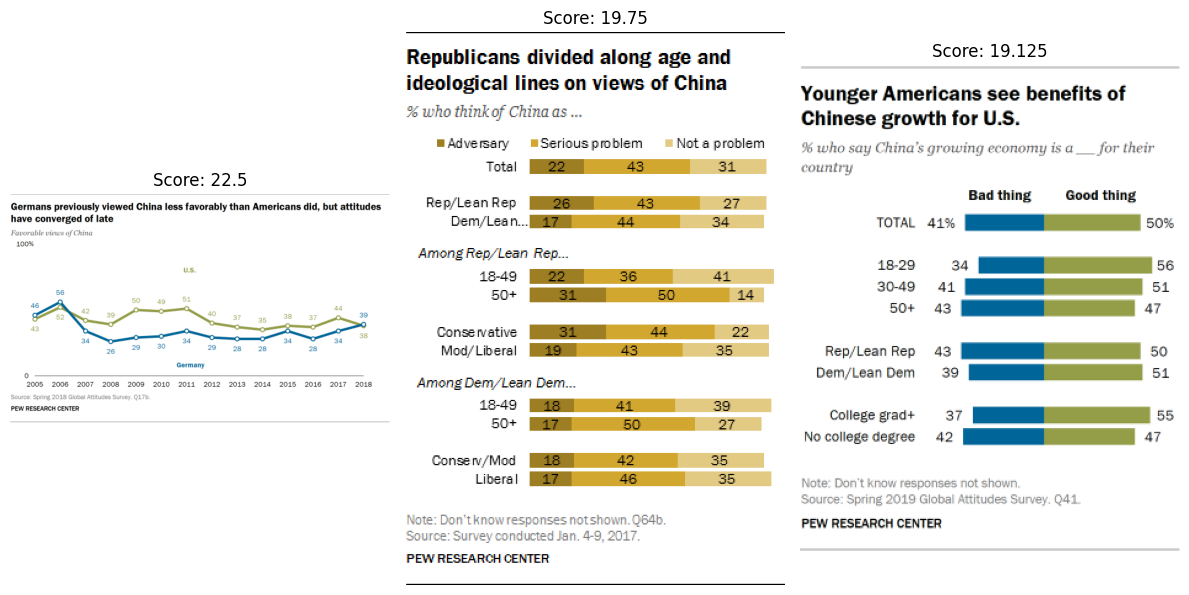

In [2]:
from multi_modal import MultiModalRetriever

retriever = MultiModalRetriever()

# query = "What was the percentage of favorable views of China among Americans in 2015?"
query = "In which country did the highest favorable view of China reach 56%?"

ret_results = retriever.search(query, verbose=True)

## Generation with Qwen2.5 VLM

In [3]:
from multi_modal import MultiModalGenerator 

generator = MultiModalGenerator()

images = [retriever.load_image(res['metadata']['image_name']) for res in ret_results]
gen_result = generator.generate(query, images=images, verbose=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


The graph shows that in Germany, the highest favorable view of China reached 56% in 2006. This is indicated by the green line representing Germany's data points, which peaks at 56% in 2006 before declining slightly in subsequent years.


## End-to-end Visual RAG

In [4]:
from datasets import Dataset

refined_dset_dir = f"{ROOT_DIR}/refined_chartqa/val-100_qwen25_7b"
refined_dset = Dataset.load_from_disk(refined_dset_dir)
refined_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'qwen25_7b_query', 'qwen25_7b_label'],
    num_rows: 100
})

In [5]:
safe_dset = refined_dset.filter(lambda row: row["label"] == row["qwen25_7b_label"])
safe_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'qwen25_7b_query', 'qwen25_7b_label'],
    num_rows: 70
})

In [6]:
import multi_modal
import importlib; importlib.reload(multi_modal)
from multi_modal import MultiModalRAG

rag = MultiModalRAG(retriever=retriever, generator=generator)

Query: What is the difference in death rates from mental health and substance use disorders between Sweden and Malta in 2004?


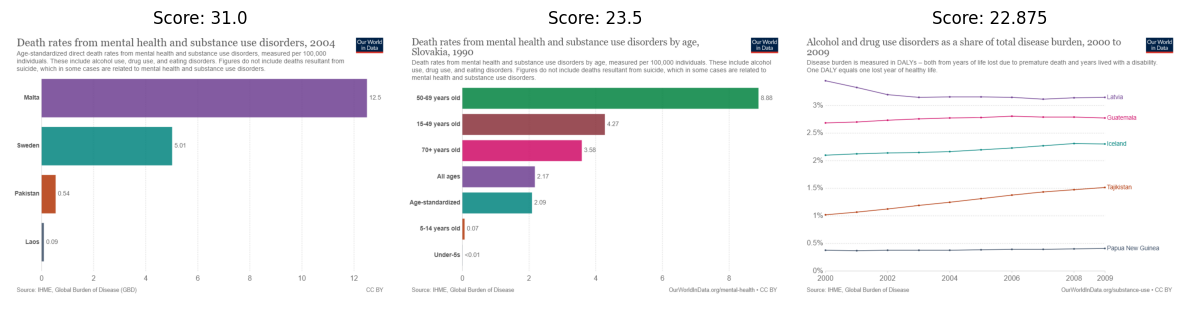

The death rate from mental health and substance use disorders in Sweden in 2004 was 5.01 per 100,000 individuals, while in Malta it was 12.5 per 100,000 individuals. The difference in death rates between these two countries is 12.5 - 5.01 = 7.49 per 100,000 individuals.
GT Answer: 7.49
{'ret_recall': 1, 'gen_correctness': 1}

Query: In the chart showing death rates from substance use disorders in 1995, how many countries are represented?


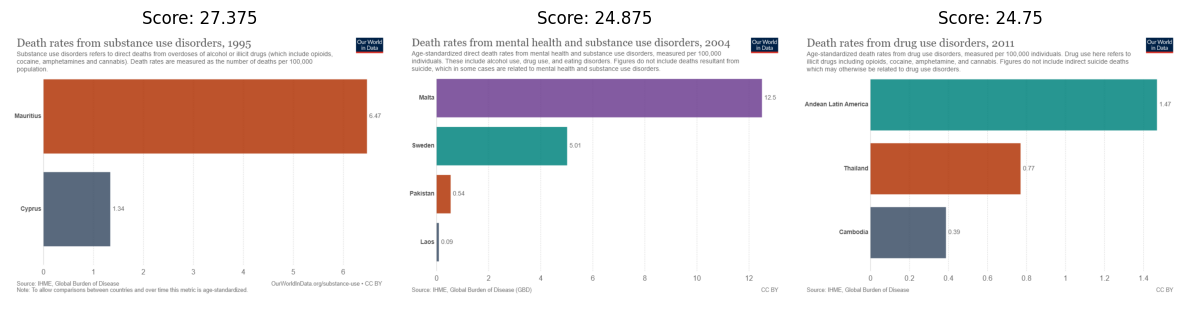

The chart showing death rates from substance use disorders in 1995 represents two countries: Mauritius and Cyprus.
GT Answer: 2
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the sum of the recycling rates for Spain and Canada in 1980?


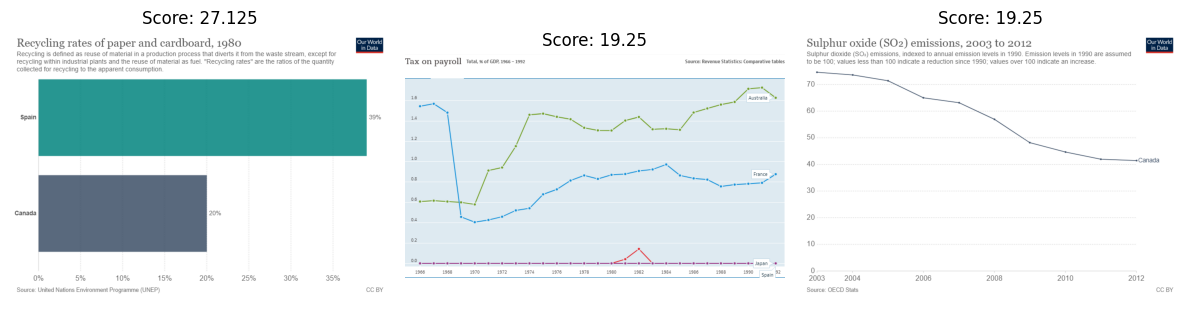

The recycling rate for Spain in 1980 was 39%, and for Canada, it was 20%. The sum of these two rates is:

39% + 20% = 59%

So, the sum of the recycling rates for Spain and Canada in 1980 is 59%.
GT Answer: 59
{'ret_recall': 1, 'gen_correctness': 1}

Query: What cancer type has a disease burden rate of 40.49 DALYs per 100,000 individuals?


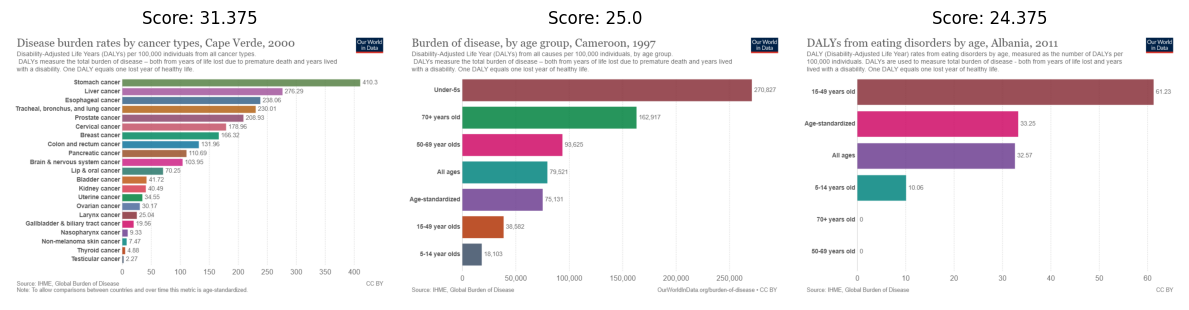

The cancer type with a disease burden rate of 40.49 DALYs per 100,000 individuals is kidney cancer.
GT Answer: Kidney cancer
{'ret_recall': 1, 'gen_correctness': 1}

Query: What percentage of people viewed Ennahda unfavorably in 2014?


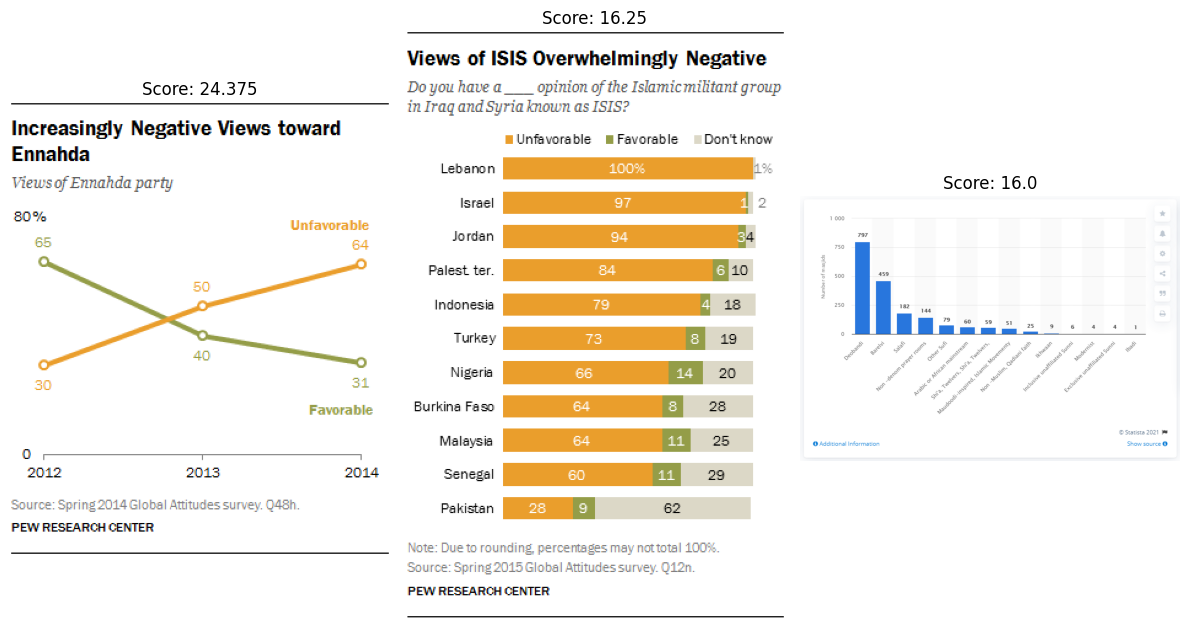

In 2014, 64% of people viewed Ennahda unfavorably according to the chart.
GT Answer: 64
{'ret_recall': 1, 'gen_correctness': 1}

Query: Which country had the highest death rate from mental health and substance use disorders in 2004?


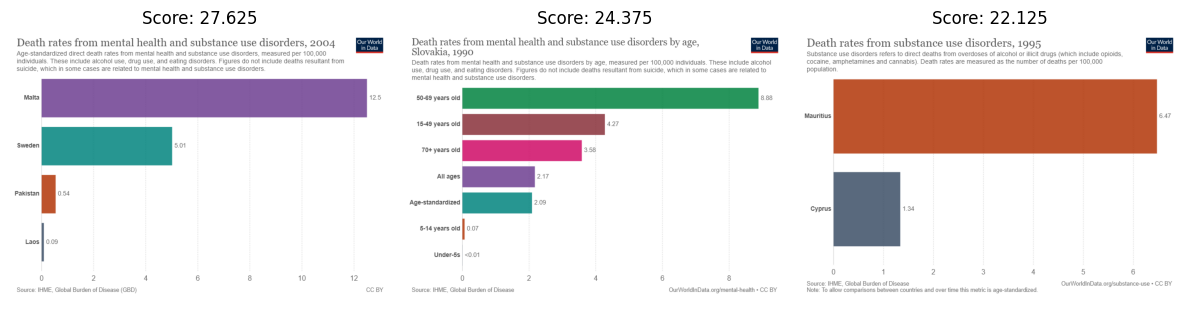

The country with the highest death rate from mental health and substance use disorders in 2004, according to the chart, is Malta with a rate of 12.5 deaths per 100,000 individuals.
GT Answer: Malta
{'ret_recall': 1, 'gen_correctness': 1}

Query: What is the difference in the number of child deaths from diarrheal diseases caused by unsafe water source compared to zinc deficiency?


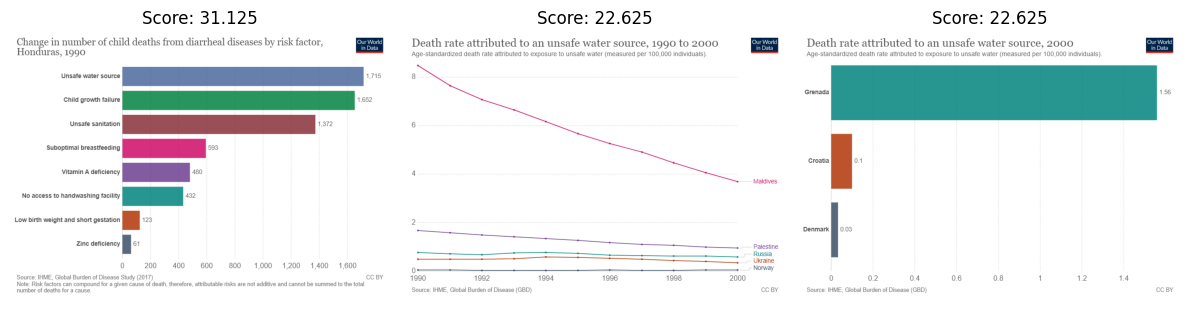

The difference in the number of child deaths from diarrheal diseases caused by unsafe water source compared to zinc deficiency is 1,654 (1,715 - 61 = 1,654).
GT Answer: 1654
{'ret_recall': 1, 'gen_correctness': 1}

Query: What percentage of cumulative plastic exports did the United States contribute between 1988 and 2016?


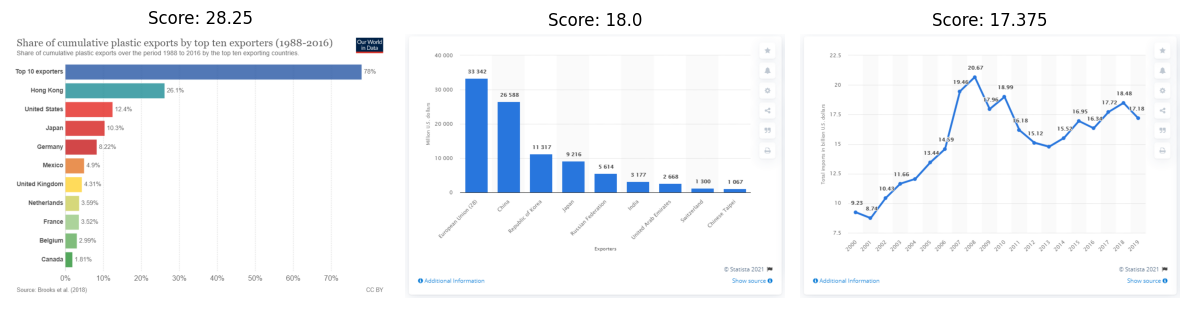

The United States contributed 12.4% to the cumulative plastic exports between 1988 and 2016, according to the chart.
GT Answer: 0.124
{'ret_recall': 1, 'gen_correctness': 1}

Query: What percentage of all blacks believe our country has made the changes needed to give blacks equal rights with whites?


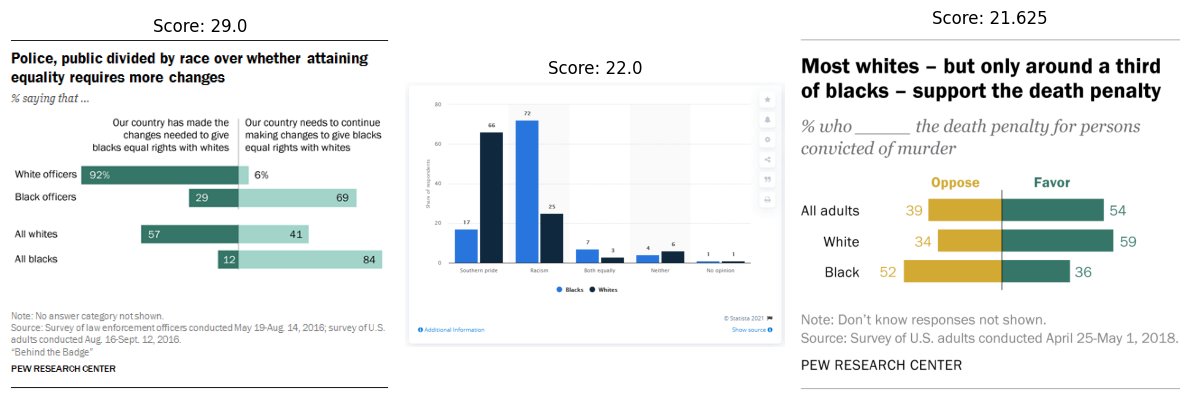

According to the first chart, 12% of all blacks believe that our country has made the changes needed to give blacks equal rights with whites.
GT Answer: 12
{'ret_recall': 1, 'gen_correctness': 1}

Query: What category consistently has the lowest percentage throughout the period from December 2008 to September 2011?


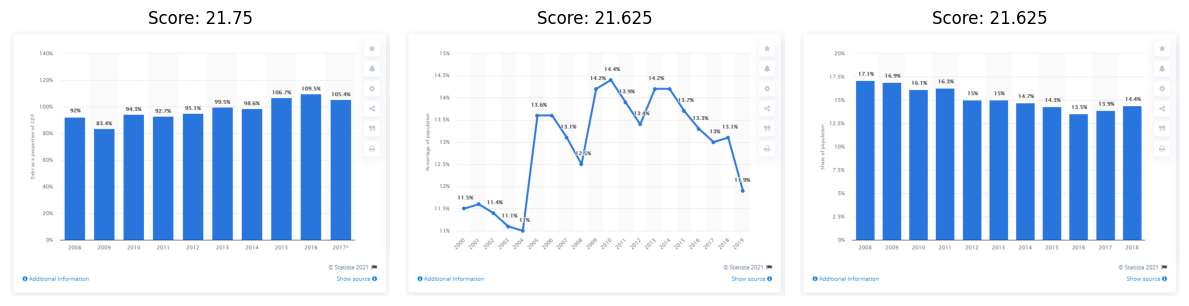

The category that consistently has the lowest percentage throughout the period from December 2008 to September 2011 is "Share of population" (as shown in the third chart). The percentages for this category range from 13.5% in 2016 to 17.1% in 2008, which is significantly lower than the other categories shown in the first two charts.
GT Answer: Mostly good news
{'ret_recall': 0, 'gen_correctness': 0}



In [7]:
for row in safe_dset.shuffle(seed=42).select(range(10)):
    query = row["qwen25_7b_query"]
    gt_answer = row["qwen25_7b_label"][0]
    gt_image_id = row["image_id"]
    
    print(f"Query: {query}")
    ret_results, gen_result = rag.run(query=query, verbose=True)
    print(f"GT Answer: {gt_answer}")
    
    metrics = rag.evaluate(query, ret_results, gen_result, gt_image_id, gt_answer)
    print(metrics)
    
    print("=" * 120 + "\n")

# rag._aggregate_metrics()

## Visual RAG Evaluation

In [8]:
from pathlib import Path

save_dir = Path(refined_dset_dir).parent / f"{Path(refined_dset_dir).stem}_rag_results"

dset, metrics = rag.run_and_evaluate_all(safe_dset, save_dir=save_dir)
display(dset)

Visual RAG Inference and Evaluation:   0%|          | 0/70 [00:00<?, ?it/s]

Saving RAG results to /h/ws_sabbasi/scratch/td2_usecase/data/refined_chartqa/val-100_qwen25_7b_rag_results


Saving the dataset (0/1 shards):   0%|          | 0/70 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'qwen25_7b_query', 'qwen25_7b_label', 'ret_images', 'gen_answer', 'ret_recall', 'gen_correctness'],
    num_rows: 70
})

In [9]:
display(metrics)

,ret_recall,gen_correctness
mean,0.8714,0.7286
std,0.3347,0.4447


## Observation

The retrieval index consists of all unique images in the validation split of ChartQA. A set of 100 randomly selected ChartQA samples were refined using a VLM. Among these, 70 samples had refined answers that were consistent with the ground-truth labels, suggesting that the question intent likely remained unchanged. The Visual RAG pipeline (Colpali + Qwen2.5) was evaluated on these 70 samples using two metrics:
- **Retrieval Recall**: The proportion of correctly retrieved images relative to the ground-truth -> **87.14%**
- **Generator Correctness**: A VLM is prompted to judge the correctness of the model’s response against the ground-truth label -> **72.86%**
- Given that ChartQA images contain a substantial amount of contextual text and information, and that the refined questions are of acceptable quality for RAG, the refined ChartQA dataset may be a strong candidate for a visual RAG use case.